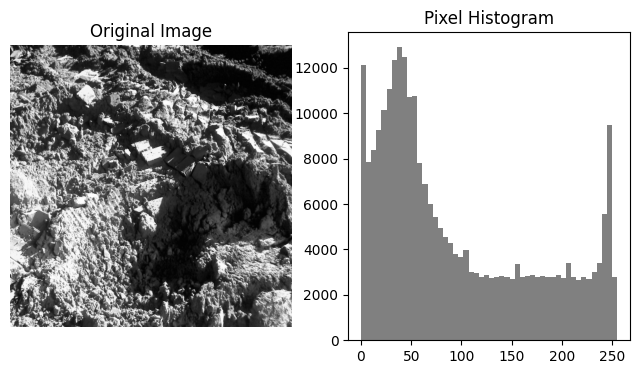

In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt

# Load grayscale lunar image
img = cv2.imread(
    r"C:\Sakshi\LunaShape\data\rim\data\calibrated\20230831\ch3_rim_nc1_20230831T2202457723_d_img_gnh_2_0.jpg",
    cv2.IMREAD_GRAYSCALE
)

img = cv2.resize(img, (512,512))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title("Original Image"); plt.axis("off")
plt.subplot(1,2,2); plt.hist(img.ravel(), bins=50, color="gray"); plt.title("Pixel Histogram")
plt.show()


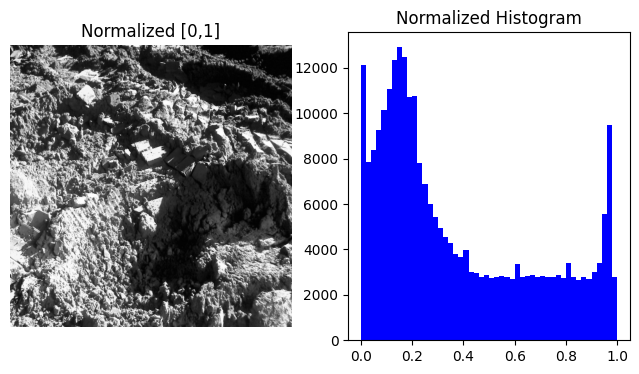

In [2]:
#Normalizing the image 
I = img.astype(np.float32)/255.0

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(I, cmap="gray"); plt.title("Normalized [0,1]"); plt.axis("off")
plt.subplot(1,2,2); plt.hist(I.ravel(), bins=50, color="blue"); plt.title("Normalized Histogram")
plt.show()


In [3]:
#Sun Vector for meta data 
sun_az_deg = 135  # replace with Chandrayaan metadata
sun_el_deg = 45

az = np.deg2rad(sun_az_deg); el = np.deg2rad(sun_el_deg)
s = np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)], dtype=np.float32)
print("Sun vector:", s)


Sun vector: [-0.5         0.5         0.70710677]


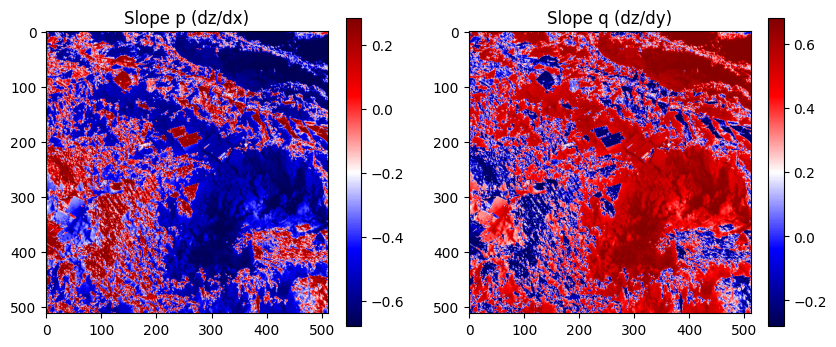

In [4]:
#Lambertian small-slope estimation

#to understand the slope intensity on x and y terrain

lam = 0.02
sx, sy, sz = s
den = (sx*sx + sy*sy + lam)

p = (sx*(sz - I))/den   # slope in x
q = (sy*(sz - I))/den   # slope in y

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(p, cmap="seismic"); plt.colorbar(); plt.title("Slope p (dz/dx)")
plt.subplot(1,2,2); plt.imshow(q, cmap="seismic"); plt.colorbar(); plt.title("Slope q (dz/dy)")
plt.show()


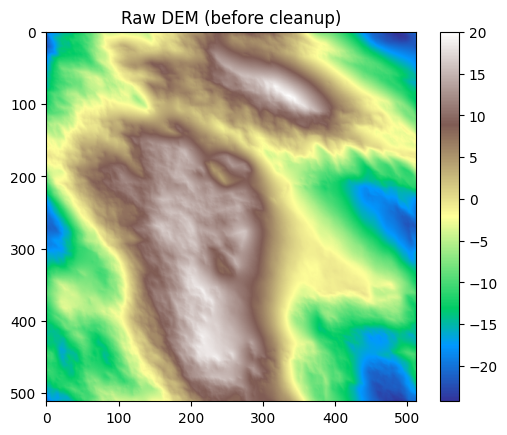

In [5]:
#Integrate Slopes DEM 
from scipy.fft import fft2, ifft2

def frankot_chellappa(p,q):
    rows, cols = p.shape
    wx = np.tile(np.fft.fftfreq(cols), (rows,1))
    wy = np.tile(np.fft.fftfreq(rows), (cols,1)).T
    Wx, Wy = 2*np.pi*wx, 2*np.pi*wy
    denom = Wx**2 + Wy**2; denom[0,0]=1e-6
    Z = (-1j*Wx*fft2(p) - 1j*Wy*fft2(q)) / denom
    return np.real(ifft2(Z))

z = frankot_chellappa(p,q)

plt.imshow(z, cmap="terrain"); plt.colorbar(); plt.title("Raw DEM (before cleanup)")
plt.show()


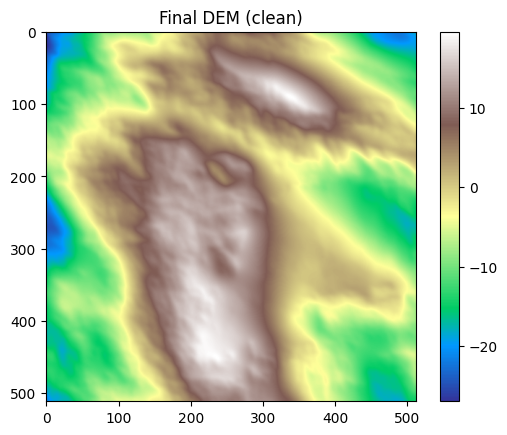

In [6]:
#Detrend and smoothen 
from scipy.ndimage import gaussian_filter

h,w = z.shape
yy,xx = np.mgrid[0:h,0:w]
A = np.c_[xx.ravel(), yy.ravel(), np.ones(h*w)]
coef, *_ = np.linalg.lstsq(A, z.ravel(), rcond=None)
plane = (A@coef).reshape(h,w)
z_dt = z - plane
z_dem = gaussian_filter(z_dt, sigma=2)

plt.imshow(z_dem, cmap="terrain"); plt.colorbar(); plt.title("Final DEM (clean)")
plt.show()


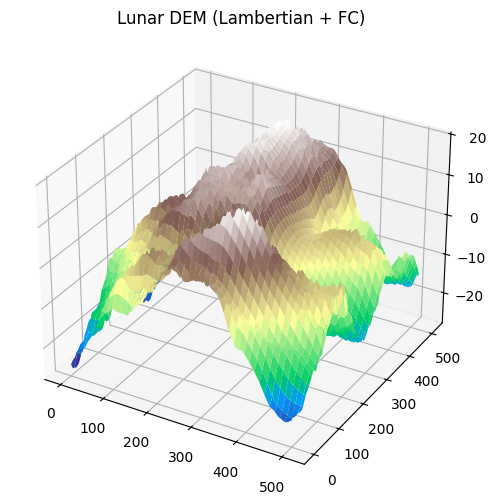

In [7]:
#3D visualization
from mpl_toolkits.mplot3d import Axes3D

X,Y = np.meshgrid(np.arange(w), np.arange(h))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, z_dem, cmap="terrain", linewidth=0, antialiased=True)
ax.set_title("Lunar DEM (Lambertian + FC)")
plt.show()


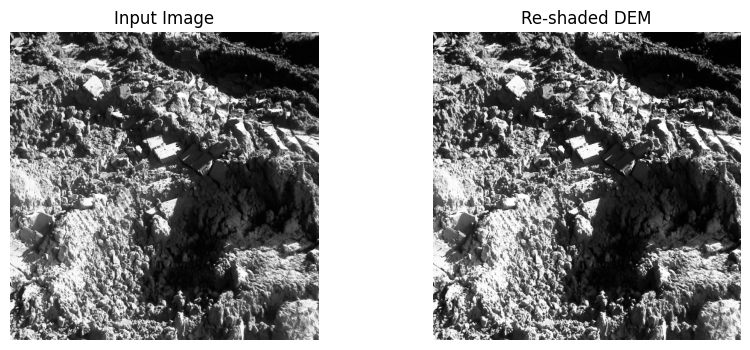

In [8]:
#Comparison between original Image VS DEM
n = np.dstack((-p,-q,np.ones_like(p)))
n /= np.linalg.norm(n,axis=2,keepdims=True)+1e-6
I_pred = np.clip((n @ s).squeeze(),0,1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(I, cmap="gray"); plt.title("Input Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(I_pred, cmap="gray"); plt.title("Re-shaded DEM"); plt.axis("off")
plt.show()
